# MNIST Example
Similar to how most programming languages have a "Hello World" exercise, machine learning has MNIST.

MNIST is a simple computer vision dataset. It consists of imagess of handwritten digits like:

(insert image)

It also includes labels for each image, telling us what digit it is.

We are going to train a model to look at the images and predict what digits they are. Let's start with a very simple model called Softmax Regression.

## MNIST Data

The MNIST data is hosted [here](http://yann.lecun.com/exdb/mnist/). To download and read in the data automatically:

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


The MNIST data is split into three parts:
1. 55,000 data points of training data (`mnist.train`)
2. 10,000 data points of test data (`mnist.test`)
3. 5,000 data points of validation data (`mnist.validation`)

Every MNIST data has 2 parts:
1. an image of a handwritten digit (call it "x")
2. corresponding label (call it "y")

Each image is 28px by 28px, we can interpert it as a big array of numbers. Let's flatten it into a vector of $28\times 28=784$ numbers. 

From this perspective, the MNIST images are just a bunch of points in a 784-dimensional vector space. 

The result is that `mnist.train.images` is a tensor with the shape of `[55000, 784]`. The first dimension is an index to the list of images and the second dimension is the index for each pixel in each image. Each entry in the tensor is a pixel intensity between 0 and 1, for a particular pixel in a particular image.

Since we want the digit of a handwritten sample, we're going to want our labels as "one-hot vectors". A one-hot vector is a vector which is 0 in most dimensions and 1 in a single dimension. For example, 3 would be represented as `[0,0,0,1,0,0,0,0,0,0]`. So, `mnist.train.labels` is a `[55000, 10]` array of floats.

## Visualize the dataset


In [1]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape((28, 28)), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

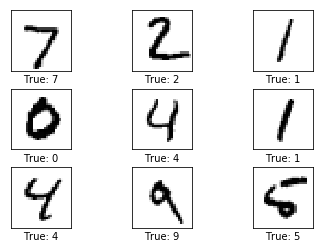

In [5]:
import numpy as np
import matplotlib.pyplot as plt
# Get the first images from the test-set.
images = mnist.test.images[0:9]

# Get the true classes for those images.
mnist.test.cls = np.argmax(mnist.test.labels, axis=1)
cls_true = mnist.test.cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

## Implementing the Regression

Let's get cracking!

In [4]:
import tensorflow as tf
x = tf.placeholder(tf.float32, [None, 784])

Quick recap, `x` is a `placeholder`, a value that we will input when we ask TensorFlow to run a computation. We will represent the MNIST images as 2-D tensor of floating-point numbers, with a shape of `[None, 784]`, `None`, means that a dimension can be of any length.

We also need the weights and biases. 

In [5]:
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))

`W` has a shape of `[784,10]` as we want to multiply the 784-dimensional image vectors by `W` to produce 10-dimensional vectors of evidence for the difference classes. `b` has a shape of `[10]` as we can add it to the output.

We can now define our model:

In [6]:
y = tf.nn.softmax(tf.matmul(x, W) + b)

We multiply `x` with `W` in that order as `x` has shape `[None, 784]` and `W` has shape `[784, 10]`. Small trick to deal with `x` being a 2D tensor with multiple inputs. 

## Training

We will try to minimize the error, which represents how far off our model is from the our desired outcome. 

A common function to determine the loss of a model is called "cross-entropy". It is defined as:

$$H_{y'}=-\sum_{i} y_i' \log(y_i)$$

Where:
- $y$ is our predicted probability distribution
- $y'$ is the true distribution (one-hot vector with digit labels)

To implement cross entropy we need to first add a new placeholder to input the correct answers

In [8]:
y_ = tf.placeholder(tf.float32, [None, 10])

Next, implement the cross entropy function: $-\sum_{i} y_i' \log(y_i)$

In [9]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), 
                                              reduction_indices = [1]))

`tf.reduce_sum`

computes the sum of elements across dimensions of a tensor.

```python
reduce_sum(
    input_tensor,
    axis=None,
    keep_dims=False,
    name=None,
    reduction_indices=None
)
```
For example:

```python
# 'x' is [[1, 1, 1]
#         [1, 1, 1]]
tf.reduce_sum(x) ==> 6
tf.reduce_sum(x, 0) ==> [2, 2, 2]
tf.reduce_sum(x, 1) ==> [3, 3]
tf.reduce_sum(x, 1, keep_dims=True) ==> [[3], [3]]
tf.reduce_sum(x, [0, 1]) ==> 6
```
See [TensorFlow API](https://www.tensorflow.org/api_docs/python/tf/reduce_sum) for more details

What is going on?

1. compute logarithm of each element of `y`
2. multiply each `y_` with the corresponding element of `tf.log(y)`
3. `tf.reduce_sum` adds the elements in the second dimension of `y`
4. `tf.reduce_mean` computes the mean over all the examples in the batch

Let's implement the optimization algorithm. In this case, we are using gradient descent algorithm. There are [plenty](https://www.tensorflow.org/api_guides/python/train#Optimizers) more to experiment with.

In [12]:
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

In [22]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
for _ in range(400):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

Using small batches of random data is called stochastic training -- in this case, stochastic gradient descent. We would like to use train on the entire data set but that that's expensive.

## Evaluating our model

Let's figure out if we predicted the right label. `tf.argmax` is an extrememly helpful function that returns the index of the highest entry in a tensor along some axis.

`tf.argmax(y, 1)` is the predicted label while `tf.argmax(y_, 1)` is the actual label. We can use `tf.equal` to check if our prediction matches the truth.

In [23]:
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))

In [24]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

0.9113


92% is not too bad but we can definitely do better. Stay tuned!

### References
- https://www.tensorflow.org/get_started/mnist/beginners
- https://www.oreilly.com/learning/not-another-mnist-tutorial-with-tensorflow